In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import torch
import json
import time
from sklearn.linear_model import LinearRegression
import os
from collections import defaultdict
from PIL import Image
from IPython.display import Image, display
import warnings
warnings.filterwarnings('ignore')

In [5]:
exps = {
    "baseline": "Baseline",
    "elr": "ELR",
    "selective": "Selective Loss"
}
exp_colors = {
    "baseline": "firebrick",
    "elr": "olivedrab",
    "selective": "royalblue"
}

In [6]:
# Train Epoch: (\d+) $$ ?\d+/\d+ $(\d+)%$$$
# image_to_text_mean_rank: ([\d.]+)\simage_to_text_median_rank: ([\d.]+)\simage_to_text_R@1: ([\d.]+)\simage_to_text_R@5: ([\d.]+)\simage_to_text_R@10: ([\d.]+)\stext_to_image_mean_rank: ([\d.]+)\stext_to_image_median_rank: ([\d.]+)\stext_to_image_R@1: ([\d.]+)\stext_to_image_R@5: ([\d.]+)\stext_to_image_R@10: ([\d.]+)\sclip_val_loss: ([\d.]+).*val_generative_loss: ([\d.]+)


# Just Normal Output Logs

In [7]:
# Training
contrastive_loss = {exp: [] for exp in exps}
caption_loss = {exp: [] for exp in exps}

# Eval
clip_loss = {exp: [] for exp in exps}
generative_loss = {exp: [] for exp in exps}
rank_keys = ["mean", "median", "1", "5", "10"]
img_text_metrics = {f"img_text_{rk}": {exp: [] for exp in exps} for rk in rank_keys}
text_img_metrics = {f"text_img_{rk}": {exp: [] for exp in exps} for rk in rank_keys}
imagenet_metrics = {f"top{rk}": {exp: [] for exp in exps} for rk in [1, 5]}

In [8]:
def read_out_log(file_path, exp):
    with open(file_path, "r") as f:
        lines = f.readlines()
        for i in range(len(lines)):
            if "(100%)" in lines[i] and "Train" in lines[i]:
                losses = re.search(r"Contrastive_loss: ([\d.]+).*Caption_loss: ([\d.]+)", lines[i])
                contrastive_loss[exp].append(float(losses.group(1)))
                caption_loss[exp].append(float(losses.group(2)))
            elif "@" in lines[i]:
                for rk in rank_keys:
                    if rk.isnumeric():
                        img_text_metrics[f"img_text_{rk}"][exp].append(float(re.search(r"image_to_text_R@{}: ([\d.]+)".format(rk), lines[i]).group(1)))
                        text_img_metrics[f"text_img_{rk}"][exp].append(float(re.search(r"text_to_image_R@{}: ([\d.]+)".format(rk), lines[i]).group(1)))
                    else:
                        img_text_metrics[f"img_text_{rk}"][exp].append(float(re.search(r"image_to_text_{}_rank: ([\d.]+)".format(rk), lines[i]).group(1)))
                        text_img_metrics[f"text_img_{rk}"][exp].append(float(re.search(r"text_to_image_{}_rank: ([\d.]+)".format(rk), lines[i]).group(1)))
                clip_loss[exp].append(float(re.search(r"clip_val_loss: ([\d.]+)", lines[i]).group(1)))
                generative_loss[exp].append(float(re.search(r"val_generative_loss: ([\d.]+)", lines[i]).group(1)))
                if "imagenet" in lines[i]:
                    for rk in [1, 5]:
                        imagenet_metrics[f"top{rk}"][exp].append(float(re.search(r"-val-top{}: ([\d.]+)".format(rk), lines[i]).group(1)))


In [9]:
for exp in exps:
    read_out_log(f"checkpoints/{exp}/{exp}_out.log", exp)

### ImageNet

In [10]:
for key in imagenet_metrics:
    print(key)
    for exp in exps:
        print(exp, imagenet_metrics[key][exp][-1])
    print()

top1
baseline 0.082
elr 0.083
selective 0.0685

top5
baseline 0.2134
elr 0.2156
selective 0.1832



### CLIP

In [11]:
for key in img_text_metrics:
    print(key)
    for exp in exps:
        print(exp, img_text_metrics[key][exp][-1])
    print()

img_text_mean
baseline 2358.2079
elr 2363.7034
selective 3033.8937

img_text_median
baseline 105.0
elr 108.0
selective 194.0

img_text_1
baseline 0.109
elr 0.1079
selective 0.0926

img_text_5
baseline 0.2385
elr 0.2344
selective 0.2041

img_text_10
baseline 0.2983
elr 0.2932
selective 0.2556



In [12]:
for key in text_img_metrics:
    print(key)
    for exp in exps:
        print(exp, text_img_metrics[key][exp][-1])
    print()

text_img_mean
baseline 2456.347
elr 2467.5792
selective 3066.6569

text_img_median
baseline 101.0
elr 105.0
selective 182.0

text_img_1
baseline 0.1127
elr 0.1112
selective 0.0952

text_img_5
baseline 0.2419
elr 0.2371
selective 0.2057

text_img_10
baseline 0.3007
elr 0.2956
selective 0.2578



## Captioning Metrics

Baseline:

{"dataset": "mscoco_captions", "model": "coca_ViT-B-32", "pretrained": "/home/sandeepmukh/open_clip/src/logs/coca_coyo_baseline_4/checkpoints/epoch_100.pt", "task": "captioning", "metrics": {"Bleu_1": 0.17672835175451507, "Bleu_2": 0.07565489680903821, "Bleu_3": 0.034623598080123524, "Bleu_4": 0.01697722087433417, "METEOR": 0.07305713111547212, "ROUGE_L": 0.15935293353439198, "CIDEr": 0.03973819529855504, "SPICE": 0.03186848139645699}, "language": "en"}

ELR:

{"dataset": "mscoco_captions", "model": "coca_ViT-B-32", "pretrained": "/home/sandeepmukh/open_clip/src/logs/coca_coyo_elr_11/checkpoints/epoch_100.pt", "task": "captioning", "metrics": {"Bleu_1": 0.1606134541652125, "Bleu_2": 0.0652953130027717, "Bleu_3": 0.027791786061154098, "Bleu_4": 0.012840336108348137, "METEOR": 0.06655500710244817, "ROUGE_L": 0.14490948727077035, "CIDEr": 0.03317901006340626, "SPICE": 0.028571814761247323}, "language": "en"}

Selective:

???

# Looking at Samples

In [13]:
checkpoints = np.arange(10, 101, 10)
num_samples = 64
seq_length = 75

In [14]:
start = time.time()
eval_data = {exp: {chkpt: None for chkpt in checkpoints} for exp in exps}
for exp in exps:
    for chkpt in checkpoints:
        with open(f"eval_logs/{exp}/checkpoint_{chkpt}_metrics.json", "r") as f:
            eval_data[exp][chkpt] = json.loads(f.read())
end = time.time()
print("Main metrics reading time:", round((end - start) / 60, 2))

Main metrics reading time: 3.06


In [15]:
# start = time.time()
# sub_data = {exp: {chkpt: None for chkpt in checkpoints} for exp in exps}
# for exp in exps:
#     for chkpt in checkpoints:
#         with open(f"eval_logs/{exp}/checkpoint_{chkpt}_submetrics.json", "r") as f:
#             sub_data[exp][chkpt] = json.loads(f.read())
# end = time.time()
# print("Sub metrics reading time:", round((end - start) / 60, 2))

In [16]:
# Dictionary keys:
# 'saved_epoch'
# 'all_loss', 'all_gen_loss'
# 'all_labels', 'all_logits', 'all_logit_scales', 'all_predictions'
# 'all_per_position_losses', 'all_per_token_losses'

## Generative loss over time

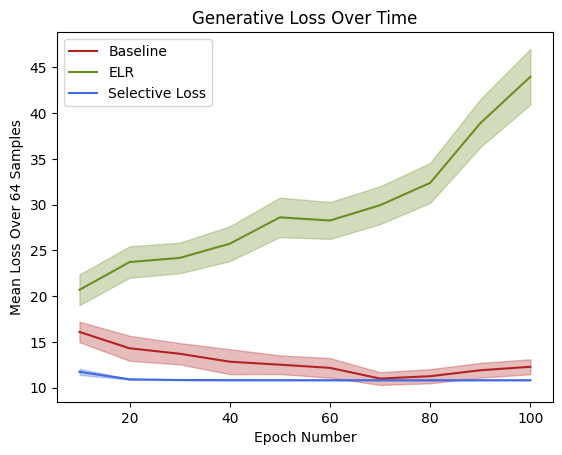

In [17]:
plt.figure()

for exp in exps:
    gen_losses = np.array([eval_data[exp][chkpt]["all_gen_loss"] for chkpt in checkpoints])
    mean_losses = np.mean(gen_losses, axis = 1)
    plt.plot(checkpoints, mean_losses, label = exps[exp], color = exp_colors[exp])
    std_losses = np.std(gen_losses, axis = 1)
    plt.fill_between(checkpoints, mean_losses - std_losses, mean_losses + std_losses, color = exp_colors[exp], alpha = 0.3)

plt.title("Generative Loss Over Time")
plt.xlabel("Epoch Number")
plt.ylabel("Mean Loss Over 64 Samples")
plt.legend()
plt.show()

## Average per position loss at last epoch

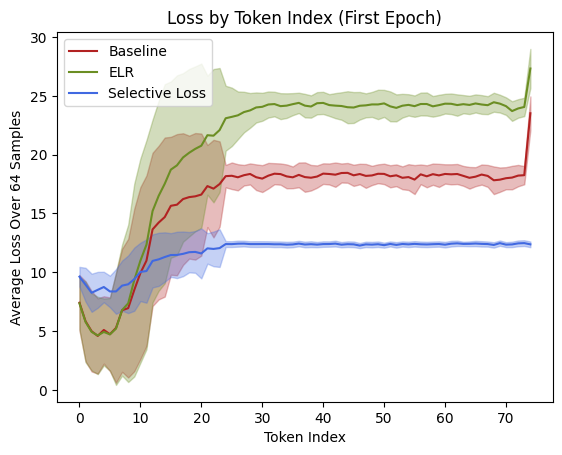

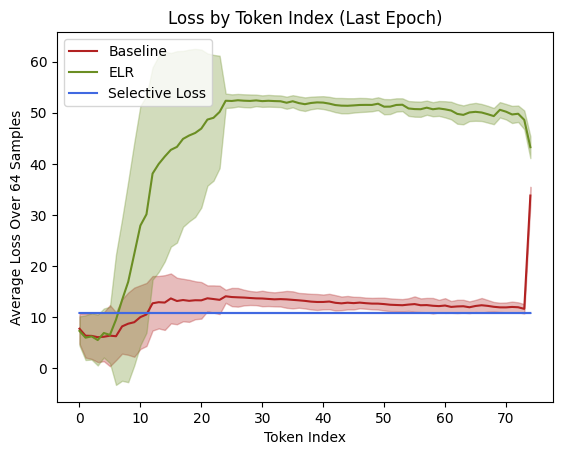

In [21]:
cois = [10, 100]
plt.figure()

for coi in cois:
    for exp in exps:
        ppl = np.array(eval_data[exp][coi]["all_per_position_losses"])
        avg_ppl = np.mean(ppl, axis = 0)
        plt.plot(range(seq_length), avg_ppl, label = exps[exp], color = exp_colors[exp])
        std_ppl = np.std(ppl, axis = 0)
        plt.fill_between(range(seq_length), avg_ppl - std_ppl, avg_ppl + std_ppl, alpha = 0.3, color = exp_colors[exp])

    plt.title(f"Loss by Token Index ({'First' if coi == 10 else 'Last'} Epoch)")
    plt.xlabel("Token Index")
    plt.ylabel("Average Loss Over 64 Samples")
    plt.legend()
    plt.show()

## H/L token categories

In [17]:
threshold = 0.2
cats = ["H→H", "H→L", "L→H", "L→L"]

def classify_token_losses(exp):
    initial_losses = eval_data[exp][10]["all_per_token_losses"]
    final_losses = eval_data[exp][100]["all_per_token_losses"]
    vocab = initial_losses.keys()
    L_mean = np.mean([loss for loss in final_losses.values()])

    categories = {cat: [] for cat in cats}
    loss_tracker = {cat: [[] for _ in range(len(checkpoints))] for cat in cats}
    avg_losses = {cat: [0 for _ in range(len(checkpoints))] for cat in cats}
    std_losses = {cat: [0 for _ in range(len(checkpoints))] for cat in cats}
    for token in vocab:
        losses = np.array([eval_data[exp][chkpt]["all_per_token_losses"][token] for chkpt in checkpoints])
        model = LinearRegression().fit(checkpoints.reshape(-1, 1), losses)
        a = model.coef_[0]
        b = model.intercept_
        L_start = b
        L_end = a * 10 + b  # 10 checkpoints
        delta_L = L_end - L_start
        if delta_L < -threshold:
            cat = "H→L"
        elif delta_L > threshold:
            cat = "L→H"
        elif -threshold <= delta_L <= threshold:
            if losses[-1] <= L_mean:
                cat = "L→L"
            else:
                cat = "H→H"
        categories[cat].append(token)
        for i in range(len(losses)):
            loss_tracker[cat][i].append(losses[i])
    for cat in cats:
        for i in range(len(checkpoints)):
            mean, avg = np.mean(loss_tracker[cat][i]), np.std(loss_tracker[cat][i])
            avg_losses[cat][i] = mean
            std_losses[cat][i] = avg
    return categories, loss_tracker, avg_losses, std_losses

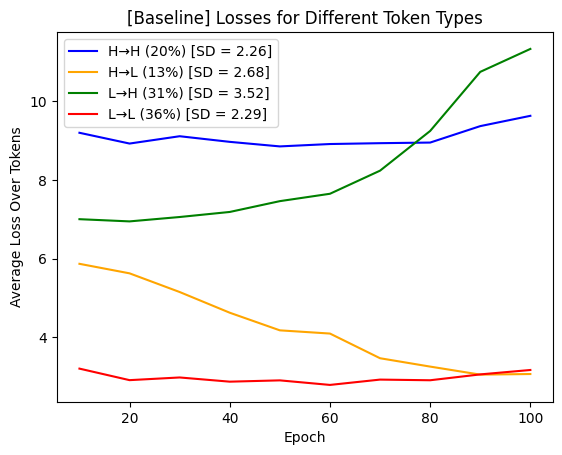

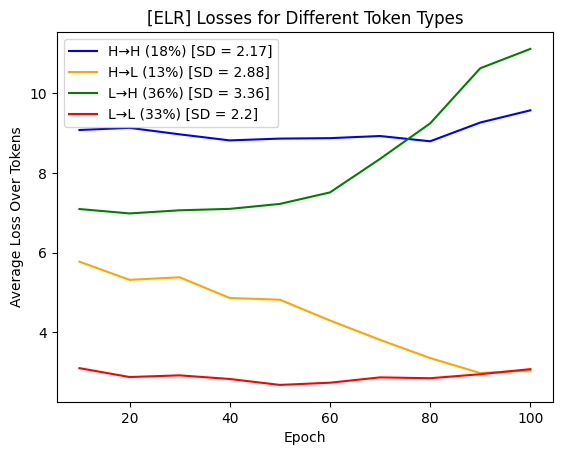

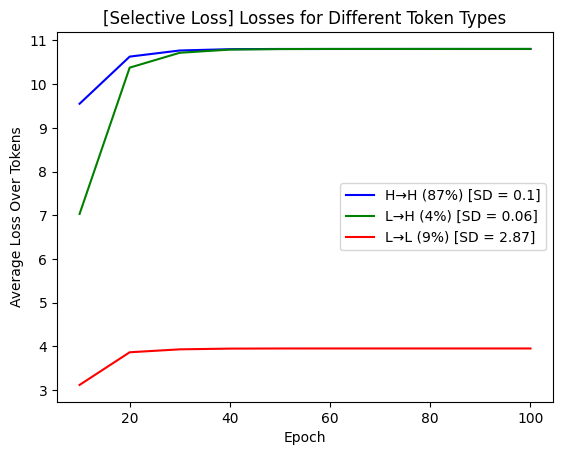

In [18]:
colors = ["blue", "orange", "green", "red"]
cat_colors = {cats[i]: colors[i] for i in range(4)}
for exp in exps:
    plt.figure()
    loss_categories, loss_tracker, avg_losses, std_losses = classify_token_losses(exp)
    vocab_size = sum([len(loss_categories[cat]) for cat in loss_categories])
    for cat in cats:
        if len(loss_categories[cat]) > 0:
            plt.plot(checkpoints, avg_losses[cat],
                     label = f"{cat} ({round(len(loss_categories[cat]) / vocab_size * 100)}%) [SD = {round(np.mean(std_losses[cat]), 2)}]",
                     color = cat_colors[cat])
            # avg_losses[cat], std_losses[cat] = np.array(avg_losses[cat]), np.array(std_losses[cat])
            # plt.fill_between(checkpoints, avg_losses[cat] + std_losses[cat], avg_losses[cat] - std_losses[cat], alpha = 0.2, color = cat_colors[cat])
    plt.title(f"[{exps[exp]}] Losses for Different Token Types")
    plt.xlabel("Epoch")
    plt.ylabel("Average Loss Over Tokens")
    plt.legend()
    plt.show()

Looking at sample number 24


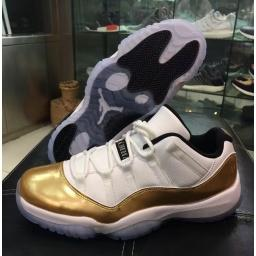

Ground truth caption: person in white and gold for the summer lovely
[('person', 'L→L'), ('in', 'L→L'), ('white', 'L→L'), ('and', 'L→L'), ('gold', 'L→H'), ('for', 'L→L'), ('the', 'L→L'), ('summer', 'L→L'), ('lovely', 'L→H')] 

Baseline:
nike  in  black  shoes  black  dress  shoes  best  2  sneakers  :  ™  (  (  (  (  (  ~  ~  ~  ~  ~  --  --  --  --  --  --  |  =  =  --  --  --  --  --  --  --  </  --  --  </  </  </  </  </  </  . - </  </  </  </  </  . </  </  </  </  </  </  </  </  </  </  </  ? ? </  </  </  </  </  </  <end_of_text>
ELR:
nike  with  white  sneakers  black  shoes  boys  nike  shoes  girl  <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <en

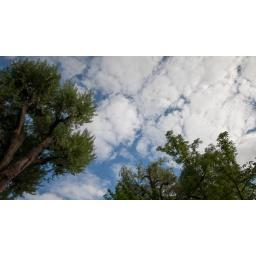

Ground truth caption: a time - lapse video of the sky .
[('a', 'L→L'), ('time', 'L→L'), ('-', 'L→L'), ('lapse', 'L→L'), ('video', 'L→L'), ('of', 'L→L'), ('the', 'L→L'), ('sky', 'L→H'), ('.', 'L→L')] 

Baseline:
cloud  cloud  for  lapse  shot  of  the  volcano  and  <end_of_text> world  far  >  >  <  <  <  <  <  <  ​  ​  ​  ​  ​  ​  ??  ??  ??  ​  ​  ​  $  ano  $  $  $  $  $  $  ano  ano  ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? _ _ #  }  }  ? ? _ means  ? ? ? - ? <end_of_text>
ELR:
the  morning  to  lapse  photo  of  a  clouds  over  <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <en

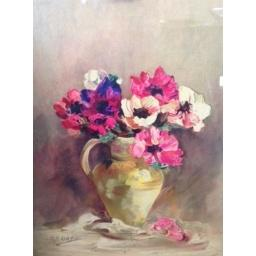

Ground truth caption: person , 20th century oil on board still life of flowers in a vase , signed bottom left
FUCK 20th
[('person', 'L→L'), (',', 'L→L'), ('20th', 'H→H'), ('century', 'L→L'), ('oil', 'L→L'), ('on', 'L→L'), ('board', 'L→H'), ('still', 'H→H'), ('life', 'L→L'), ('of', 'L→L'), ('flowers', 'H→L'), ('in', 'L→L'), ('a', 'L→L'), ('vase', 'L→H'), (',', 'L→L'), ('signed', 'L→L'), ('bottom', 'L→H'), ('left', 'L→H')] 

Baseline:
bouquet  with  please  2  2  century  limited  ,  canvas  ,  life  flowers  flowers  in  pink  white  ,  1  r  -  ,  (  style  >  ®  ®  ®  ®  >  >  >  }  }  }  }  }  }  }  }  }  }  }  }  }  }  }  }  ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ll  <end_of_text>
ELR:
bouquet  holding  floral  0  2  century  <end_of_text> painting  canvas  <end_of_text> life  with  flowers  <end_of_text> a  landscape  <end_of_text> 1  and  with  .  <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_te

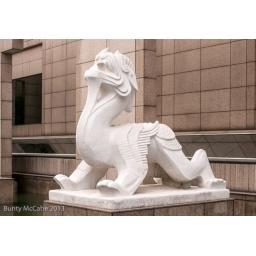

Ground truth caption: the description of this sculpture is in the previous photo .
[('the', 'L→L'), ('description', 'H→H'), ('of', 'L→L'), ('this', 'L→L'), ('sculpture', 'H→L'), ('is', 'L→L'), ('in', 'L→L'), ('the', 'L→L'), ('previous', 'L→H'), ('photo', 'L→L'), ('.', 'L→L')] 

Baseline:
angel  angel  on  the  bust  titled  still  the  style  image  "  it  model  model  ™  <  [  +  <  +  …  …  /  /  /  /  /  &  &  &  !  }  }  }  é  !  é  é  !  !  !  !  }  }  }  }  }  }  }  }  }  }  }  }  }  }  ? ? ? }  }  ? ? ? }  }  }  }  }  ? ? ? }  ? <end_of_text>
ELR:
load  white  on  the  item  is  not  the  collections  style  i  it  <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_

In [31]:
sample_dir = "./eval_samples/"
samples = os.listdir(sample_dir)

chkpt = 100
loss_categories = {exp: classify_token_losses(exp)[0] for exp in exps}
loss_categories = {exp: {cat: [token.strip() for token in tokens] for cat, tokens in cats.items()} for exp, cats in loss_categories.items()}
model_predictions = {exp: eval_data[exp][chkpt]["all_predictions"] for exp in exps}

for idx in [24, 36, 42, 63]:
    print("Looking at sample number", idx)
    display(Image(filename = f"{sample_dir}img_{idx}.jpg"))
    with open(f"{sample_dir}cap_{idx}.txt", "r") as f:
        caption = f.read().strip()
    print("Ground truth caption:", caption)
    caption_labels = []
    lc = loss_categories["baseline"]
    for token in caption.split():
        token = token.strip()
        for cat in cats:
            added = False
            if token in lc[cat]:
                added = True
                caption_labels.append((token, cat))
                break
        if not added:
            print("FUCK", token)
            caption_labels.append((token, "H→H"))
    print(caption_labels, "\n")
    for exp in exps:
        print(f"{exps[exp]}:")
        model_caption = model_predictions[exp][idx]
        print(model_caption)
    print("\n\n\n")

## High/low loss tokens in captions

In [37]:
def categorize(loss, quartiles):
    if loss <= quartiles[0]:
        return "low"
    elif loss <= quartiles[1]:
        return "low med"
    elif loss <= quartiles[2]:
        return "high med"
    else:
        return "high"

In [40]:
captions = {"baseline": "chinese  to  your  pink  place  to  photograph  your  nail  nails",
            "elr": "tokyo  to  the  best  area  for  go  your  the  band",
            "input": "where 's the best place to show off your nails ? right in front of the castle , of course !"}
for exp in captions:
    if exp != "input":
        per_token_losses = eval_data[exp][100]["all_per_token_losses"]
        per_token_losses = {key.strip(): value for key, value in per_token_losses.items()}
    else:
        # per_token_losses = defaultdict(list)
        # for key, value in eval_data["baseline"][100]["all_per_token_losses"].items():
        #     per_token_losses[key].append(value)
        # for key, value in eval_data["elr"][100]["all_per_token_losses"].items():
        #     per_token_losses[key].append(value)
        # per_token_losses = {key: sum(values) / len(values) for key, values in per_token_losses.items()}
        per_token_losses = eval_data["baseline"][100]["all_per_token_losses"]
        per_token_losses = {key.strip(): value for key, value in per_token_losses.items()}
    caption = captions[exp]
    losses = []
    for token in caption.split():
        token = token.strip()
        try:
            losses.append(per_token_losses[token])
        except KeyError:
            losses.append(max(per_token_losses.values()))
    quartiles = np.percentile(losses, [25, 50, 75])
    loss_labels = [categorize(loss, quartiles) for loss in losses]
    print("Exp:", exp)
    print("Caption:", caption)
    print(loss_labels)
    print("\n")

Exp: baseline
Caption: chinese  to  your  pink  place  to  photograph  your  nail  nails
['high', 'low', 'low med', 'high med', 'low', 'low', 'high', 'low med', 'high', 'low med']


Exp: elr
Caption: tokyo  to  the  best  area  for  go  your  the  band
['high med', 'low med', 'low', 'low med', 'high med', 'low', 'high med', 'high med', 'low', 'high med']


Exp: input
Caption: where 's the best place to show off your nails ? right in front of the castle , of course !
['high', 'low med', 'low', 'low med', 'low', 'low med', 'high', 'high med', 'high med', 'low med', 'high med', 'high', 'low', 'high', 'low', 'low', 'high', 'low med', 'low', 'high med', 'high med']




## Run through captioning examples for each model at epoch 100

In [32]:
sample_dir = "./eval_samples/"
samples = os.listdir(sample_dir)
for idx in range(num_samples):
    print("Looking at sample number", idx)
    with open(f"{sample_dir}cap_{idx}.txt", "r") as f:
        caption = f.read().strip()
    print("Ground truth caption:", caption)
    for exp in exps:
        log = f"{exps[exp]} model:\n"
        for chkpt in [100]:
            log += f"{chkpt}. {eval_data[exp][chkpt]['all_predictions'][idx]}\n"
        print(log)

Looking at sample number 0
Ground truth caption: the - bedroom stone cottage can sleep people
Baseline model:
100. photo  old  fields  has  house  on  be  5  .  make  early  _  _  _  _  _  [ <  * * * * }  }  }  }  }  }  }  }  }  -- -- -- -- % % % % % % % % % % % % % % % % % % % % % % % % % % ** ** fla  ** ** ** -- swarovski  ond  !!!!  -- -- </  <end_of_text>

ELR model:
100. photo  old  maine  of  head  at  be  right  up  <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text>

## Attending to text or to image?

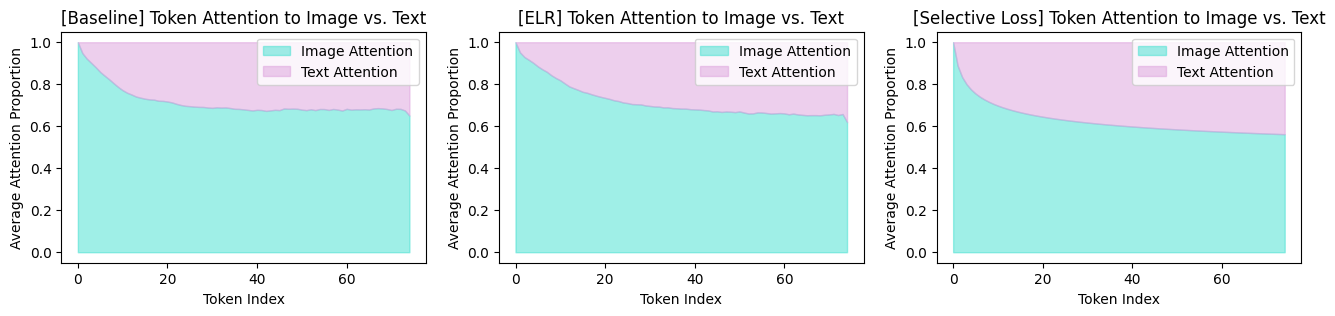

In [31]:
fig, axes = plt.subplots(1, 3, figsize = (16, 3))

for k, exp in enumerate(exps):
    with open(f"eval_logs/{exp}/checkpoint_100_metrics.json", "r") as f:
        test = json.loads(f.read())
    indices = np.arange(seq_length)
    layers = ["0"]
    
    for i in range(len(layers)):
        avg_img_attn_ratios = np.zeros(seq_length)
        avg_text_attn_ratios = np.zeros(seq_length)
        for j in range(num_samples):
            token_attn_split = test["all_token_attn_splits"][j]
            img_attn, text_attn = token_attn_split[layers[i]]
            avg_img_attn_ratios += np.array(img_attn)
            avg_text_attn_ratios += np.array(text_attn)
        avg_img_attn_ratios = avg_img_attn_ratios / num_samples
        avg_text_attn_ratios = avg_text_attn_ratios / num_samples
    
        axes[k].fill_between(indices, 0, avg_img_attn_ratios, color = "turquoise", alpha = 0.5, label = "Image Attention")
        axes[k].fill_between(indices, avg_img_attn_ratios, avg_img_attn_ratios + avg_text_attn_ratios, color = "plum", alpha = 0.5, label = "Text Attention")
        layer_name = "First Layer" if layers[i] == "0" else "Last Layer"
        axes[k].set_title(f"[{exps[exp]}] Token Attention to Image vs. Text")
        axes[k].set_xlabel("Token Index")
        axes[k].set_ylabel("Average Attention Proportion")
        axes[k].legend()
plt.show()